# Introduction


In this notebook, we are going analyze a list of transactions from a dataset and build a model that detects fraudulent transactions with the help of machine learning algorithms.




### Importing libraries

In [2]:

import pandas as pd
import numpy as np
from datetime import datetime


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

## Loading the data

### Transactions data


**Features of this dataset:**
* **user_id**: unique ID of the user
* **signup_time**: Timestamp of the user signing up for the website 
* **purchase_time**: Timestamp of the transaction
* **purchase_value**: Value of the transaction
* **device_id** : The unique ID of the device
* **source** : How did the user land on the website
* **browse**r: The browser used for the transactions
* **sex**: gender of the user
* **age**: age of the user
* **ip_address**: IP address of the user

**Target variable (class)**

* **0**  - non fraudulent transaction
* **1**  - fraudulent transaction

In [88]:
# Load transactions data
data = pd.read_csv(".\\data.\\Fraud_Data.csv")
data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2/24/2015 22:55,4/18/2015 2:47,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,6/7/2015 20:39,6/8/2015 1:38,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,1/1/2015 18:52,1/1/2015 18:52,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,4/28/2015 21:13,5/4/2015 13:54,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,7/21/2015 7:09,9/9/2015 18:40,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,5/21/2015 6:03,7/9/2015 8:05,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,8/1/2015 22:40,8/27/2015 3:37,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,4/6/2015 7:35,5/25/2015 17:21,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,4/21/2015 23:38,6/2/2015 14:01,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,1/25/2015 17:49,3/23/2015 23:05,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [87]:
vals = data['class'].value_counts()
print(vals)

0    136961
1     14151
Name: class, dtype: int64


### IP address to Country mapping data

This dataset allows to derive the country of the user based on his IP address.  

In [4]:
# Loading mapping data
ip_country = pd.read_csv(".\\data.\\IpAddress_to_Country.csv")

ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Data Exploration

In [6]:
# Shape of the dataset
print("Rows : {}".format(data.shape[0]))
print("Columns : {}".format(data.shape[1]))

Rows : 151112
Columns : 11


At first glance we can notice the following points in our data:

* No missing values accross the dataset
* No incoherent values
* Data is largely skewed as we have only 9.36% of fraudulent transactions

In [7]:
data.describe(include="all")

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,135572,121599,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,1/6/2015 12:10,1/6/2015 12:10,NaN,EQYVNEGOFLAWK,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,29,27,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000


### Conversion to datetime

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


"signup_time" and "purchase_time" are formatted as object type. They have to be converted to datetime. It can be done using the method to_datetime().

In [8]:
# Converting time columns from object to datetime format
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

data[['signup_time', 'purchase_time']].dtypes

signup_time      datetime64[ns]
purchase_time    datetime64[ns]
dtype: object

### Time features extraction and exploration

In [10]:
# Purchase month and day
data['purchase_month'] = data['purchase_time'].dt.month
data['purchase_day'] = data['purchase_time'].dt.day

# Sign-up month and day
data['signup_month'] = data['signup_time'].dt.month
data['signup_day'] = data['signup_time'].dt.day

From the plots below, we can see a clearly that:
* most fraudulent transactions occur in January
* within the first half of the month

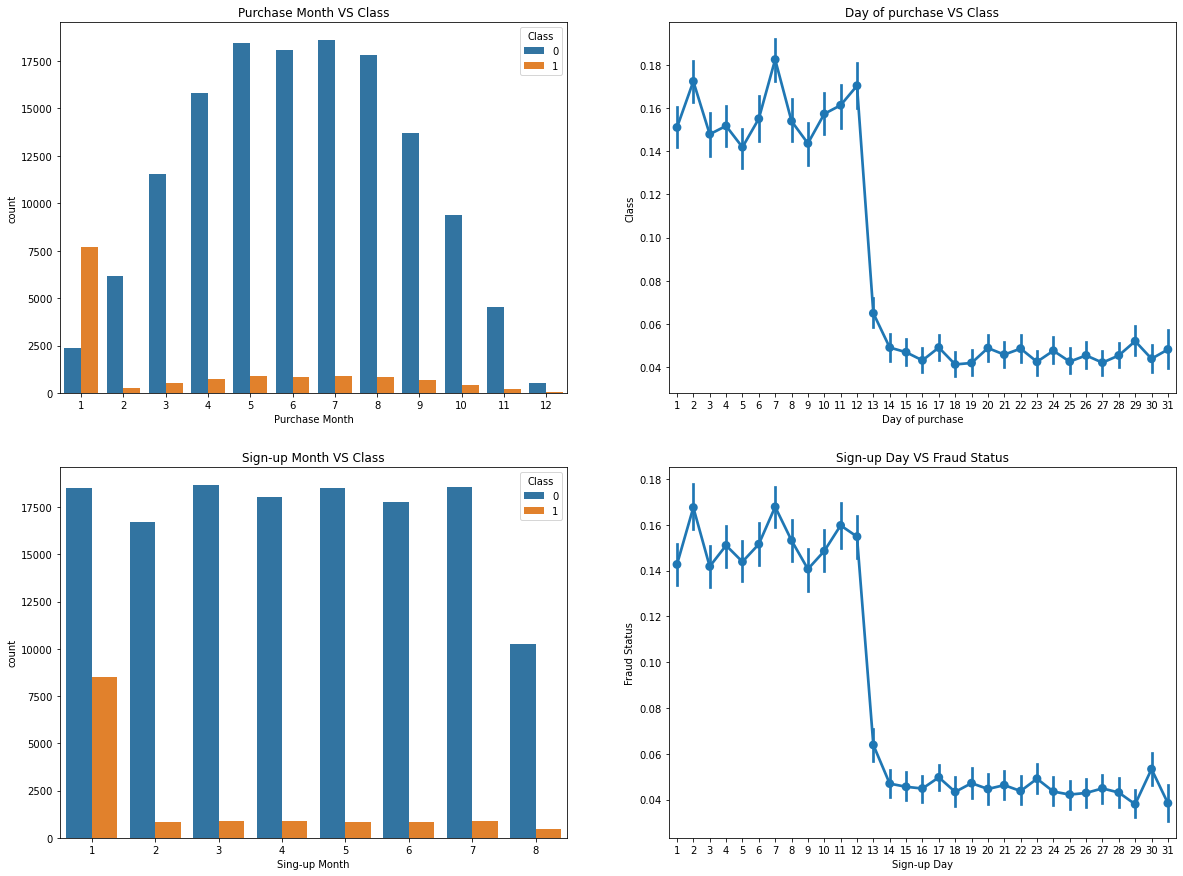

In [19]:
# Plotting time features VS fraud status
fig, ax = plt.subplots(2,2, figsize=(20,15))

# Purchase Month VS Class
plt.subplot(2, 2, 1)
ax[0,0] = sns.countplot(x='purchase_month', hue='class', data=data)
ax[0,0].set_title('Purchase Month VS Class')
ax[0,0].set_xlabel('Purchase Month')
ax[0,0].legend(title='Class')

# Purchase Day VS Class
plt.subplot(2, 2, 2)
ax[0,1] = sns.pointplot(x='purchase_day', y='class', data=data)
ax[0,1].set_title('Day of purchase VS Class')
ax[0,1].set_xlabel('Day of purchase')
ax[0,1].set_ylabel('Class')

# Sign-up Month VS Class
plt.subplot(2, 2, 3)
ax[1,0] = sns.countplot(x='signup_month', hue='class', data=data)
ax[1,0].set_title('Sign-up Month VS Class')
ax[1,0].set_xlabel('Sing-up Month')
ax[1,0].legend(title='Class')

# Sign-up Day VS Class
plt.subplot(2, 2, 4)
ax[1,1] = sns.pointplot(x='signup_day', y='class', data=data)
ax[1,1].set_title('Sign-up Day VS Fraud Status')
ax[1,1].set_xlabel('Sign-up Day')
ax[1,1].set_ylabel('Fraud Status')

# Display figure
plt.show()


### Calculating the time spent 

We can calculate the time spent between transactions by subtracting the signup time form the purchase time.

In [20]:
# Computing time spent
data['time_delta'] = (data['purchase_time'] - data['signup_time']).astype('timedelta64[s]')

The below plot confirms that most of fraudulent transactions come from new users

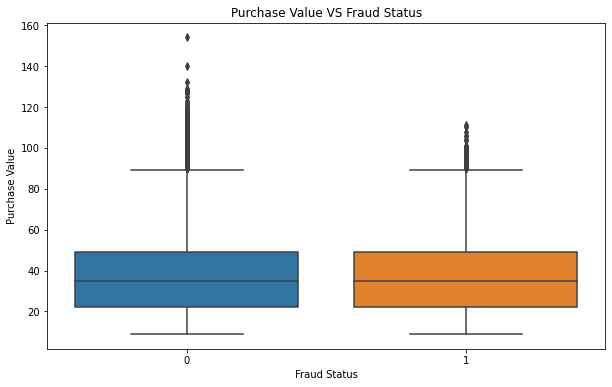

In [22]:
# Purchase value VS fraud status
plt.figure(figsize=(10,6))
sns.boxplot(x='class' , y='purchase_value', data=data)

plt.xlabel('Fraud Status')
plt.ylabel('Purchase Value')
plt.title('Purchase Value VS Fraud Status')

plt.show()

Looking at the distribution of purchase value data, **we cannot conclude on a relationship** with our target data since **both fraudulent and non-fraudulent transactions fall into the same range**. However let's keep this feature for our model.

### Device ID

In [23]:
data['device_id'].nunique()

137956

The device ID will not be used for classification as it is too vague.

### Source

In [24]:
# Count the values for source
data['source'].value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

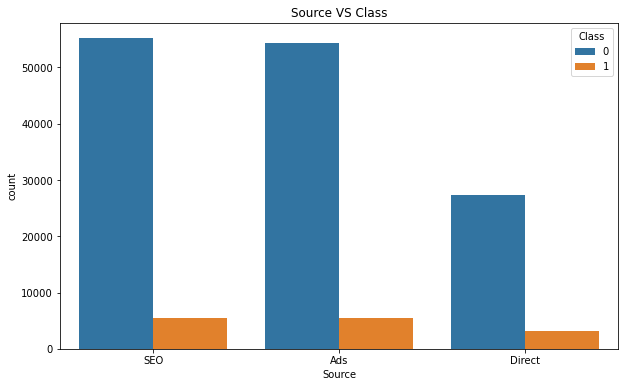

In [26]:
# Source VS Class
plt.figure(figsize=(10,6))
sns.countplot(x='source', hue='class', data=data)
plt.title('Source VS Class')
plt.xlabel('Source')
plt.legend(title='Class')
plt.show()

### Browser

In [27]:
# Value counts for Browser feature
data['browser'].value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

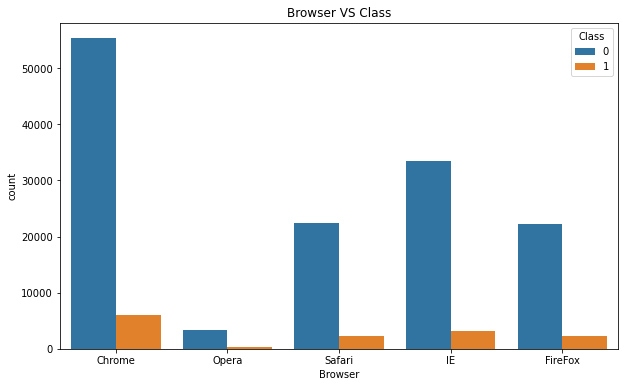

In [28]:
# Browser VS Fraud Status
plt.figure(figsize=(10,6))
sns.countplot(x="browser", hue="class", data=data)
plt.title('Browser VS Class')
plt.xlabel('Browser')
plt.legend(title='Class')
plt.show()

As seen from the plot above, most transactions were done from Chrome followed by Internet Explorer.

### IP address

The country can be derived from the IP address using the IpAddress_to_Country.csv dataset.

In [29]:
def transform_ip(arg):
    try:
        return ip_country.country[(ip_country.lower_bound_ip_address < arg) & (ip_country.upper_bound_ip_address > arg)].iloc[0]
    except IndexError:
        return "Unknown country"  

# Applying  function to the ip_address column
data["country"] = data["ip_address"].apply(transform_ip)

In [30]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,purchase_month,purchase_day,signup_month,signup_day,time_delta,country
0,22058,2015-02-24 22:55:00,2015-04-18 02:47:00,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,4,18,2,24,4506720.0,Japan
1,333320,2015-06-07 20:39:00,2015-06-08 01:38:00,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,6,8,6,7,17940.0,United States
2,1359,2015-01-01 18:52:00,2015-01-01 18:52:00,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1,1,1,1,0.0,United States
3,150084,2015-04-28 21:13:00,2015-05-04 13:54:00,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,5,4,4,28,492060.0,Unknown country
4,221365,2015-07-21 07:09:00,2015-09-09 18:40:00,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,9,9,7,21,4361460.0,United States


In [32]:
# Number of countries
data['country'].nunique()

182

## Filtering out unnecessary data

### Dropping features

After our EDA, we conclude that we can drop the following columns:

* user_id: unique id, does not contain useful information
* signup_time, signup_month, signup_day: redundant with purchase_day, purchase_month and time_delta
* device_id: Does not contain useful information
* ip_address: Not useful, we derived the country from it

In [33]:
# Dropping the unecessary columns and keeping the useful ones
to_drop = ['user_id', 'signup_time', 'signup_month', 'signup_day', 'purchase_time', 'device_id', 'ip_address']
data_processed = data.drop(columns=to_drop, axis=1)
data_processed.head()

,purchase_value,source,browser,sex,age,class,purchase_month,purchase_day,time_delta,country
0,34,SEO,Chrome,M,39,0,4,18,4506720.0,Japan
1,16,Ads,Chrome,F,53,0,6,8,17940.0,United States
2,15,SEO,Opera,M,53,1,1,1,0.0,United States
3,44,SEO,Safari,M,41,0,5,4,492060.0,Unknown country
4,39,Ads,Safari,M,45,0,9,9,4361460.0,United States


Some countries are very rare. In the following, we will not consider the countries that are represented less that 50 times.

In [34]:
# Defining a count of countries Pandas Series
country_counts = data_processed['country'].value_counts()

# Defining the list of countries to keep
to_keep = country_counts[country_counts > 50].index.values

# Filtering out data
data_processed = data_processed.loc[data_processed['country'].isin(to_keep), :].reset_index(drop=True)
data_processed.head()

,purchase_value,source,browser,sex,age,class,purchase_month,purchase_day,time_delta,country
0,34,SEO,Chrome,M,39,0,4,18,4506720.0,Japan
1,16,Ads,Chrome,F,53,0,6,8,17940.0,United States
2,15,SEO,Opera,M,53,1,1,1,0.0,United States
3,44,SEO,Safari,M,41,0,5,4,492060.0,Unknown country
4,39,Ads,Safari,M,45,0,9,9,4361460.0,United States


In [35]:
print("Number of rows in the cleaned dataset : {} rows".format(data_processed.shape[0]))
print("Number of columns in the cleaned dataset : {} columns".format(data_processed.shape[1]))

Number of rows in the cleaned dataset : 149933 rows
Number of columns in the cleaned dataset : 10 columns


## Machine Learning

This section deals with building Machine Learning Models and detecting fraudulent transactions.

### Setting the training data and the test data

In [51]:
# Listing out the feautres needed
print(data_processed.columns.values)

['purchase_value' 'source' 'browser' 'sex' 'age' 'class' 'purchase_month'
 'purchase_day' 'time_delta' 'country']


Let's define some useful variables that will help us construct our pipeline:

In [65]:
# Defining the list of selected features
f_list = ['time_delta', 'purchase_value', 'age','purchase_month',
                'purchase_day',  'source', 'browser', 'sex', 'country',
                 ]

# Indentifying the indexes of numerical and categorical features
numeric_indices = [0, 1, 2,]
categorical_indices = [3, 4, 5, 6, 7, 8]

# Defining the target variable
target_variable = 'class'

Now, let's split our explanatory variables and target variable into two separate dataframes.

In [66]:
# Features dataframe
X = data_processed.loc[:, f_list]

# Labels dataframe
y = data_processed.loc[:, target_variable]

print('Explanatory variables: ', X.columns.values)

Explanatory variables:  ['time_delta' 'purchase_value' 'age' 'purchase_month' 'purchase_day'
 'source' 'browser' 'sex' 'country']


We can now split our data into training and testing. 
The method train_test_split() can be used to do the following. 
As our data is largely skewed, we used the "stratify" parameter to reproduce the same distribution of the target labels into our training and testing data.

In [67]:
print("<<< Dividing the data into training and testing >>>")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)
print("Split completed.")
print()

<<< Dividing the data into training and testing >>>
Split completed.



In [68]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(y_train[0:5])
print(y_test[0:2])

Convert pandas DataFrames to numpy arrays
[[7124040.0 22 41 6 25 'SEO' 'Safari' 'M' 'United States']
 [6970980.0 41 33 3 27 'SEO' 'FireFox' 'F' 'United Kingdom']
 [1357200.0 28 45 2 23 'SEO' 'Chrome' 'F' 'United States']
 [5402700.0 32 36 7 28 'Direct' 'Safari' 'F' 'Unknown country']
 [8387100.0 39 29 4 13 'SEO' 'FireFox' 'M' 'Denmark']]
[[5844180.0 15 39 7 12 'Ads' 'Safari' 'F' 'Denmark']
 [3844860.0 50 35 2 22 'Ads' 'Chrome' 'M' 'Ireland']]

[0 0 0 1 0]
[0 0]


### Encoding our data

The last step before training our models is to transform and standardize our data :

* Numerical columns: Strandard scaling
* Categorical columns: One Hot encoding 

The Pipeline() and ColumnTransformer() are used to define a series of transformations to apply to specific columns.

In [69]:
# Creating a preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

In [70]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Fitting and transforming training data
X_train = preprocessor.fit_transform(X_train)

# Transforming ONLY our testing data to prevent data leakage
X_test = preprocessor.transform(X_test)

print("...Done")
print(X_train[0:5, :])

Encoding categorical features and standardizing numerical features...
...Done
  (0, 0)	0.7008257398997123
  (0, 1)	-0.8131614140682454
  (0, 2)	0.9124683309381226
  (0, 7)	1.0
  (0, 37)	1.0
  (0, 45)	1.0
  (0, 49)	1.0
  (0, 50)	1.0
  (0, 123)	1.0
  (1, 0)	0.6518847415110881
  (1, 1)	0.22402011232326413
  (1, 2)	-0.015572967191998093
  (1, 4)	1.0
  (1, 39)	1.0
  (1, 45)	1.0
  (1, 46)	1.0
  (1, 122)	1.0
  (2, 0)	-1.1431237383928081
  (2, 1)	-0.48563040573408445
  (2, 2)	1.376488980003183
  (2, 3)	1.0
  (2, 35)	1.0
  (2, 45)	1.0
  (2, 123)	1.0
  (3, 0)	0.15042656201996404
  (3, 1)	-0.2672764001779772
  (3, 2)	0.33244251960679716
  (3, 8)	1.0
  (3, 40)	1.0
  (3, 44)	1.0
  (3, 49)	1.0
  (3, 124)	1.0
  (4, 0)	1.104689697986316
  (4, 1)	0.1148431095452105
  (4, 2)	-0.47959361625705843
  (4, 5)	1.0
  (4, 25)	1.0
  (4, 45)	1.0
  (4, 46)	1.0
  (4, 50)	1.0
  (4, 66)	1.0


### Evaluation metrics

#### Interpreting the scores

* The **precision** represents the "purity" of the prediction that it indeed is a fraud transaction. In other words, it's the ratio of examples being predicted as 1s that are indeed 1s: $P = \frac{TP}{TP + FP}$ 
* The **recall** represents the ability to detect the true fraud cases. It's the ratio of examples that are true 1s and have been predicted as 1s: $R = \frac{TP}{TP + FN}$ 
* From the formulae above, one can see the the precision is maximal when there are no false positives, and the recall is maximal when there are no false negatives
* The **F1-score** is a harmonic average between Precision and Recall. It allows to account for both false positivies and false negatives, which very useful when dealing with class imbalance: $F1 = 2.\frac{P . R}{P + R}$ 

#### What do these values mean in the context of fraud detection ?

* False positives - this represent transactions that are reported as frauds but in fact are not frauds in actual
* False negatives - this represent frauds that are not detected (this is the kind of error that we want to avoid)
* In this case, **we would like to detect as much frauds as possible while having a number of false positives that is as close as possible to 0 (because we want to avoid fake alerts that would be time-consuming for the company)**

### 1.Logistic Regression

In this part, we will perform a Logistic Regression on our data. We will use the GridSearchCV module to train multiple models using a range of hyperparameters, and automatically selecting the model with the best score.

In [71]:
# Train model
print("Training in progress...")

# Defining a ranges of hyperparameters
Cs = [10**i for i in range(-4,4)] # Regularization parameter
penalties = ['none', "l1", "l2"] # Regularization penalty ('l2':Ridge, 'l1':Lasso)

# Dictionary of hyperparameters
params = {"penalty":penalties, "C":Cs}

# Defining our GridSearchCV instance
lr_grid = GridSearchCV(LogisticRegression(class_weight = "balanced"),
                    param_grid=params,
                    verbose=2,
                    cv=5, 
                    scoring="f1")

# Fitting to training data
lr_grid.fit(X_train, y_train)

Training in progress...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.0001, penalty=none ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................... C=0.0001, penalty=none, total=   2.1s
[CV] C=0.0001, penalty=none ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ........................... C=0.0001, penalty=none, total=   1.9s
[CV] C=0.0001, penalty=none ..........................................
[CV] ........................... C=0.0001, penalty=none, total=   2.0s
[CV] C=0.0001, penalty=none ..........................................
[CV] ........................... C=0.0001, penalty=none, total=   1.9s
[CV] C=0.0001, penalty=none ..........................................
[CV] ........................... C=0.0001, penalty=none, total=   1.9s
[CV] C=0.0001, penalty=l1 ............................................
[CV] ............................. C=0.0001, penalty=l1, total=   0.0s
[CV] C=0.0001, penalty=l1 ............................................
[CV] ............................. C=0.0001, penalty=l1, total=   0.0s
[CV] C=0.0001, penalty=l1 ............................................
[CV] ............................. C=0.0001, penalty=l1, total=   0.0s
[CV] C=0.0001, penalty=l1 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.4min finished


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='f1', verbose=2)

In [73]:
# Finding best parameters and the best f1 score
print("Hyperparameters that give the best score : {}\n".format(lr_grid.best_params_))
print("Best score : {}\n".format(lr_grid.best_score_))


Hyperparameters that give the best score : {'C': 0.1, 'penalty': 'l2'}

Best score : 0.6344657497080831



In [75]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = lr_grid.predict(X_train)
print("Completed")

print()

# Predictions on test set
print("Predictions on test set...")
y_test_pred = lr_grid.predict(X_test)
print("Completed")

Predictions on training set...
Completed

Predictions on test set...
Completed


In [76]:
# f1-score for training and testing sets
print("f1-score on train set : ", lr_grid.score(X_train, y_train))
print("f1-score on test set : ", lr_grid.score(X_test, y_test))

f1-score on train set :  0.6361806451612902
f1-score on test set :  0.6359143327841845


In [77]:
# classifiction report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27171
           1       0.76      0.55      0.64      2816

    accuracy                           0.94     29987
   macro avg       0.86      0.77      0.80     29987
weighted avg       0.94      0.94      0.94     29987



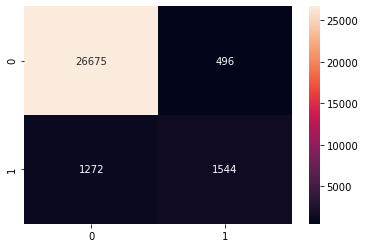

In [78]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### Inference

This model detects fraudulent transactions with a good precision. 
However, the recall is low because it misclassifies an important amount of fraudulent transactions as non-fraudulent (false negatives).

### 2. Random Forest

In this section, Random Forest classification will be used on our data to see if we can further improve the first results. 

In [79]:
# Defining a ranges of hyperparameters
max_depth = [4, 6, 8 ,10] # maximum depth of each estimator (tree)
min_samples_split = [2, 5, 10, 20, 30] # minimum samples in a node in order to be split
n_estimators = [30, 40, 50, 80, 100, 150, 200] # number of estimators (trees)

# Defining our GridSearchCV instance
rf_grid = GridSearchCV(estimator=RandomForestClassifier(class_weight="balanced"), cv=5,
                       param_grid={"max_depth":max_depth, 
                                   "min_samples_split":min_samples_split,
                                   "n_estimators":n_estimators},
                       scoring="f1",
                       verbose=2
                      )

# Fitting to training data
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV] max_depth=4, min_samples_split=2, n_estimators=30 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_split=2, n_estimators=30, total=   1.7s
[CV] max_depth=4, min_samples_split=2, n_estimators=30 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  max_depth=4, min_samples_split=2, n_estimators=30, total=   1.5s
[CV] max_depth=4, min_samples_split=2, n_estimators=30 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=30, total=   1.6s
[CV] max_depth=4, min_samples_split=2, n_estimators=30 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=30, total=   1.6s
[CV] max_depth=4, min_samples_split=2, n_estimators=30 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=30, total=   1.6s
[CV] max_depth=4, min_samples_split=2, n_estimators=40 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=40, total=   2.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=40 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=40, total=   2.2s
[CV] max_depth=4, min_samples_split=2, n_estimators=40 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=40, total=   2.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=40 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed: 86.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_split': [2, 5, 10, 20, 30],
                         'n_estimators': [30, 40, 50, 80, 100, 150, 200]},
             scoring='f1', verbose=2)

In [80]:
# Retrieving best parameters and the best score (f1 score)

print("Hyperparameters that give the best score : {}\n".format(rf_grid.best_params_))
print("Best score : {}\n".format(rf_grid.best_score_))
print("...Done.")

Hyperparameters that give the best score : {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Best score : 0.6994662444086333

...Done.


In [81]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = rf_grid.predict(X_train)
print("Completed")

print()

# Predictions on test set
print("Predictions on test set...")
y_test_pred = rf_grid.predict(X_test)
print("Completed")

Predictions on training set...
Completed

Predictions on test set...
Completed


In [82]:
# f1-score on both training and testing sets
print("f1-score on train set : ", rf_grid.score(X_train, y_train))
print("f1-score on test set : ", rf_grid.score(X_test, y_test))

f1-score on train set :  0.6998672745109354
f1-score on test set :  0.6998846597462514


In [83]:
# classifiction report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27171
           1       1.00      0.54      0.70      2816

    accuracy                           0.96     29987
   macro avg       0.98      0.77      0.84     29987
weighted avg       0.96      0.96      0.95     29987



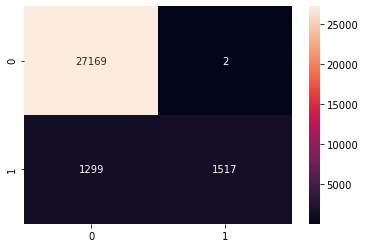

In [84]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### Inference

When we compare the random forest with logistic regression, we notice that we have slightly improved the performances in general. Particularly, we have considerably improved the precision as the number of False Positives (False frauds alerts) has dropped to nearly 0.

In [46]:
# Retrieving best parameters and the best score (f1 score)
print("Hyperparameters that give the best score : {}\n".format(xgb_grid.best_params_))
print("Best score : {}\n".format(xgb_grid.best_score_))
print("...Done.")

Hyperparameters that give the best score : {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}

Best score : 0.6997080769095605

...Done.
